# Read in raw data, transform and run classification model

In [1]:
import numpy as np
import pandas as pd
import regex as re
import json
import sklearn
import eli5

from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
def convert_json_review_to_pd(json_path):
    ''' Takes jason path, reads in all entries, then returns pd dataframe object'''

    # Read in json file
    reviews = []
    with open(json_path) as json_file:
        for rec in json_file:
            dic = json.loads(rec)
            reviews.append(dic)

    # Return pd dataframe object
    reviews_pd = pd.DataFrame.from_records(reviews)

    return reviews_pd


def prepare_text(text):
    '''Cleaning and tokenizing text for analysis'''

    text = str(text)

    # Replace contractions with full text form
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)

    # Removal of white space
    text = re.sub('\s+', ' ', text)
    # Removal of digits
    text = re.sub(r'\d+', '', text)

    # Convert words to lower case
    text = text.lower()

    # Remove other signs including punctuation
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'\'', ' ', text)

    return text


def preprocess(df):
    ''' Takes raw pd dataframe object, keeps only rating and star review, then balances set for equal balance
    between 1/2 star reviews and 4/5 star reviews '''

    # Select only subset of columns
    df = df[['overall', 'reviewText']]

    # Remove average ratings (3 stars)
    df = df[df['overall'] != 3]

    # Group poor and strong ratings together (1 and 2 vs 4 and 5)
    df['overall'] = np.where(df['overall'] <= 2, 1, 5)

    # Split low and high scores
    low_scores = df[df['overall'] == 1].reset_index()
    high_scores = df[df['overall'] == 5].reset_index()

    # Select number of rows such that dataset is balanced
    min_rows = min(low_scores.shape[0], high_scores.shape[0]) - 1
    low_scores = low_scores[0:min_rows]
    high_scores = high_scores[0:min_rows]

    # Re-merge low and high scores
    df = low_scores.append(high_scores)

    # Shuffle resulting df
    df = shuffle(df).reset_index()

    # Complete pre-processing step
    df['clean_text'] = list(map(prepare_text, df['reviewText']))

    return df


contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
                "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
                "didn't": "did not", "doesn't": "does not", "don't": "do not",
                "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
                "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
                "he'll": "he will", "he's": "he is", "how'd": "how did", "how'll": "how will",
                "how's": "how is", "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
                "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us",
                "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                "must've": "must have", "mustn't": "must not", "needn't": "need not", "oughtn't": "ought not",
                "shan't": "shall not", "sha'n't": "shall not", "she'd": "she would", "she'll": "she will",
                "she's": "she is", "should've": "should have", "shouldn't": "should not", "that'd": "that would",
                "that's": "that is", "there'd": "there had", "there's": "there is", "they'd": "they would",
                "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not",
                "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what're": "what are", "what's": "what is",
                "what've": "what have", "where'd": "where did", "where's": "where is", "who'll": "who will",
                "who's": "who is", "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                "you'll": "you will", "you're": "you are"}


def run_logistic_reg(df, product_category_name):
    '''Takes in pd df, then creates embeddings, trains logistic regression and returns most important parameters '''

    # Split train and test set
    training_data, test_data = train_test_split(df, train_size=0.8, random_state=123)
    te_y = test_data['overall']

    # Creating unigram + bigram embeddings
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1),
                                 min_df=3, lowercase=True, max_features=100000)
    bow_representation = vectorizer.fit_transform(training_data['clean_text'])
    bow_representation_test = vectorizer.transform(test_data['clean_text'])

    best_logit = LogisticRegression(C=1, solver='liblinear',
                                    penalty='l1', max_iter=1000).fit(bow_representation, training_data['overall'])

    # predict
    y_test_pred = best_logit.predict(bow_representation_test)

    # Evaluate model
    c_matrix_test = confusion_matrix(te_y, y_test_pred)
    # Accuracy
    acc = np.round(sklearn.metrics.accuracy_score(te_y, y_test_pred), 5)
    # Precision
    prec = np.round(sklearn.metrics.precision_score(te_y, y_test_pred, average=None), 3)
    prec_micro = np.round(sklearn.metrics.precision_score(te_y, y_test_pred, average='micro'), 5)
    # Recall
    rec = np.round(sklearn.metrics.recall_score(te_y, y_test_pred, average=None), 3)
    rec_micro = np.round(sklearn.metrics.recall_score(te_y, y_test_pred, average='micro'), 5)
    # F1
    f1 = np.round(sklearn.metrics.f1_score(te_y, y_test_pred, average=None), 3)
    f1_micro = np.round(sklearn.metrics.f1_score(te_y, y_test_pred, average='micro'), 5)

    # Print model results
    print('Acc: ', acc, ' Prec: ', prec, ' Rec: ', rec, ' f1: ', f1)

    # Extract vector names
    # feature_names = vectorizer.get_feature_names_out()
    feature_names = vectorizer.get_feature_names()

    # Create summary pd
    top_x, top_y = 50, 50
    weights = eli5.show_weights(estimator=best_logit, top=(top_x, top_y),
                                target_names=training_data['overall'])
    result = pd.read_html(weights.data)[0]
    result = result.drop([top_x, (top_x + 1)], axis=0)
    result['feature_number'] = list(map(lambda x: int(x[1:]), result.Feature))
    result['feature_name'] = list(map(lambda x: feature_names[x], result.feature_number))
    result['weight_num'] = list(
        map(lambda x: np.where(x[0] == "+", float(x[1:]), float(x[1:]) * -1), result['Weight?']))
    result['category'] = product_category_name

    return result


def generate_results_for_category(category_name, path_to_data, product_file_path):
    ''' Reads data, preprocesses it, runs logistic regression classification model, returns results'''

    print('- Generating results for: ' + category_name)
    
    # Read in data
    df = convert_json_review_to_pd(path_to_data + product_file_path)
    
    # Preprocess
    df = preprocess(df)
    df['tokenized_words'] = list(map(word_tokenize, df['clean_text']))
    df['number_words'] = list(map(lambda n: len(n), df['tokenized_words']))   
    
    # Print dataset stats
    print('Number of reviews: ' + str(df.shape[0]))
    print('Total words: ' + str(df['number_words'].sum()))
    
    # Run logistic regression
    reg_results = run_logistic_reg(df, category_name)
    del df
    return reg_results

In [3]:
# Data folder path
data_path = '/Users/louisgenereux/Desktop/Term 4/Text_analytics/Amazon reviews/Per product'

# Read in data, preprocess and run classification models
results_musical_instruments = generate_results_for_category('musical_instruments',
                                                            data_path, '/Musical_Instruments.json')
results_magazine_subscriptions = generate_results_for_category('magazine_subscriptions',
                                                               data_path, '/Magazine_Subscriptions.json')
results_fashion = generate_results_for_category('fashion', data_path, '/AMAZON_FASHION.json')
results_appliances = generate_results_for_category('appliances', data_path, '/Appliances.json')
results_grocery_and_food = generate_results_for_category('gourmet_food',
                                                         data_path, '/Grocery_and_Gourmet_Food_sub.json')
results_toys_and_games = generate_results_for_category('toys_and_games',
                                                         data_path, '/Toys_and_Games_sub.json')

results_df_list = [results_musical_instruments, results_magazine_subscriptions, results_fashion,
                   results_appliances, results_grocery_and_food, results_toys_and_games]

# Create list of all results
results_df_list = [results_musical_instruments, results_magazine_subscriptions, results_fashion,
                   results_appliances, results_grocery_and_food, results_toys_and_games]
final_results = pd.DataFrame()
for dataset in results_df_list:
    final_results = final_results.append(dataset)

final_results.to_csv('logistic_regression_parameters.csv')
print('- Results stored')

- Generating results for: musical_instruments
Number of reviews: 369776
Total words: 18531520
Acc:  0.91141  Prec:  [0.912 0.911]  Rec:  [0.911 0.912]  f1:  [0.911 0.912]
- Generating results for: magazine_subscriptions
Number of reviews: 32502
Total words: 1671134
Acc:  0.88417  Prec:  [0.873 0.897]  Rec:  [0.903 0.864]  f1:  [0.888 0.88 ]
- Generating results for: fashion
Number of reviews: 343594
Total words: 10050838
Acc:  0.91491  Prec:  [0.912 0.918]  Rec:  [0.919 0.911]  f1:  [0.915 0.915]
- Generating results for: appliances
Number of reviews: 160720
Total words: 8073989
Acc:  0.91059  Prec:  [0.906 0.916]  Rec:  [0.917 0.904]  f1:  [0.912 0.91 ]
- Generating results for: gourmet_food
Number of reviews: 211900
Total words: 8882375
Acc:  0.91034  Prec:  [0.908 0.912]  Rec:  [0.912 0.908]  f1:  [0.91 0.91]
- Generating results for: toys_and_games
Number of reviews: 244002
Total words: 12524412
Acc:  0.92535  Prec:  [0.925 0.926]  Rec:  [0.926 0.924]  f1:  [0.926 0.925]
- Results 

# Compare product categories across dimensions

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import dataframe_image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go

from scipy import spatial
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [5]:
def read_pretrained_embeddings(path):
    ''' Takes file path to embeddings json file, returns full embeddings in np array format'''

    embeddings_glove = {}
    with open(path) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_glove[word] = coefs

    return embeddings_glove


def euclidean_distance_word_vectors(vector_1, vector_2):
    ''' Takes 2 word embedding vectors, returns their euclidean distance'''
    distance = spatial.distance.euclidean(vector_1, vector_2)

    return distance


def find_closest_n_embeddings(target_word, full_embeddings, number_nn):
    '''
    Takes word and embedding matrix, and produces top n nearest words to a chosen word, acroos all embeddings
    Inputs:
        target_word (str): Word for which we want to find nearest neighbors
        full_embeddings (np matrix): matrix of vector encodings for all words
        number_nn (int): number of nearest neighbors
    Returns:
        list of top n words (string)
    '''

    sorted_list = sorted(full_embeddings.keys(),
                         key=lambda iteration_word: euclidean_distance_word_vectors(full_embeddings[iteration_word],
                                                                                    full_embeddings[target_word]))
    top_n_words = sorted_list[0:number_nn]
    return top_n_words


def return_n_nn_for_all_dimensions(list_of_list_dimensions, list_dimension_names, number_nn):
    '''
    Takes in list of words describing each dimension, returns pd dataframe listing n neareast neighbors for each word
    Inputs:
        list_of_list_dimensions (list of list): list of strings describing each dimension
        list_dimension_names (list of strings): name of each dimension
        number_nn (int): number of nearest neighbors
    Returns:
        pd dataframe containing the nearest neighbor to each word describing dimensions
    '''

    # Create list of all dimension nearest neighbor words
    dimension_list = []
    word_list = []
    nn_list = []
    n_dim = 0

    for dimension in list_of_list_dimensions:
        words_in_dimension = []
        for word in dimension:
            nn_all = find_closest_n_embeddings(word, embeddings_glove, number_nn)
            for iter_nn in nn_all:
                # Check that nn word is not already among nearest neighbors for this dimension
                if (iter_nn not in words_in_dimension):
                    words_in_dimension.append(iter_nn)
                    dimension_list.append(list_dimension_names[n_dim])
                    word_list.append(word)
                    nn_list.append(iter_nn)
        n_dim = n_dim + 1

    summary_nn_words = pd.DataFrame({'dimension_list': dimension_list,
                                     'word_list': word_list,
                                     'nn_list': nn_list})
    return summary_nn_words


# MEAN OR MIN?
def min_dist_from_dimension(word, dimension_summary, full_embeddings):
    '''
    Takes in a word, a pd object storing the nearest neighbors for each dimension, and a matrix object of embeddings
    Inputs:
        word (str): word which will be scored
        dimension_summary (pd df): contains one row per unique dimension, word describing dimension and nn for word
        full_embeddings (np ): matrix of vector encodings for all words
    Returns:
        pd dataframe containing 1 row per dimension, returning the distance of the dimension to the word
    '''

    current_dimension = dimension_summary.dimension_list[0]
    compared_word_index = -1

    dimension_list = []  # to store the dimension name
    dimension_distance_running_list = []  # to store the distance to each word used for a dimension
    dimension_mean_list = []  # to store the mean distance for a dimension

    for compared_word in dimension_summary.nn_list:

        # For every new word that is compared to a feature, increase the index
        compared_word_index = compared_word_index + 1

        # If the feature tests for the existing dimension, calculate distance, then append to running dist list
        if (current_dimension == dimension_summary.dimension_list[compared_word_index]):
            dist = euclidean_distance_word_vectors(full_embeddings[word], full_embeddings[compared_word])
            dimension_distance_running_list.append(dist)
        else:

            # Calculate mean for old list
            mean_past_dimension = np.mean(dimension_distance_running_list)

            # Store all details for former dimension
            dimension_list.append(current_dimension)
            dimension_mean_list.append(mean_past_dimension)

            # Change current dimension and re-initialize list
            current_dimension = dimension_summary.dimension_list[compared_word_index]
            dimension_distance_running_list = []

            # Append first value to list
            dist = euclidean_distance_word_vectors(embeddings_glove[word], embeddings_glove[compared_word])
            dimension_distance_running_list.append(dist)

    # Store all details for final former dimension
    mean_past_dimension = np.mean(dimension_distance_running_list)
    dimension_list.append(current_dimension)
    dimension_mean_list.append(mean_past_dimension)

    # Create summary, sorted from shorted distance to least
    summary_for_word = pd.DataFrame({'dimension': dimension_list,
                                     'mean_dist': dimension_mean_list})
    summary_for_word = summary_for_word.sort_values('mean_dist')

    return summary_for_word


def evaluate_paremeter_versus_dimension(summary_parameters, dimension_summary, full_embeddings, list_word_embeddings):
    '''
    Evaluates the logit parameters and attributes their 'belonging' score to a dimension, weighted by parameter importance
    Inputs:
        summary_parameters (pd df): A pd df which contains the logit weight attached to each word parameter per category
        dimension_summary (pd df): contains one row per unique dimension, word describing dimension and nn for word
        full_embeddings (np matrix): matrix of vector encodings for all words
        list_word_embeddings (list of string): a list of all words contained in parameters
    Returns:
        pd dataframe containing 1 row per parameter, with weighted
    '''

    # Create new pd dataframe
    new_df = pd.DataFrame()
    new_df['category_word'] = []
    new_df['weight'] = []
    new_df['abs_weight'] = []
    for i in dimension_names:
        new_df[i] = []

    # Keep track of word index
    feature_number = 0

    # for each word in feature list
    for feature in summary_parameters.feature_name:

        # Test if feature appears in pretrained parameters
        if feature in list_word_embeddings:

            # Extract parameter specific info
            category = summary_parameters.category[feature_number]
            weight = summary_parameters.weight_num[feature_number]
            abs_weigth = abs(weight)

            # Store basic information in df
            new_df.at[feature_number, 'category_word'] = str(category) + ('-') + str(feature)
            new_df.at[feature_number, 'weight'] = weight
            new_df.at[feature_number, 'abs_weight'] = abs_weigth

            # Create summary of dimension scores for given feature
            dist_summary_dim = min_dist_from_dimension(str(feature), dimension_summary, full_embeddings)
            # print(dist_summary_dim)
            # For each row of distance summary
            for i in range(0, dist_summary_dim.shape[0]):
                # Extract key information
                dimension_name = dist_summary_dim.dimension[i]
                dimension_summary_dist = dist_summary_dim.mean_dist[i]
                # Avoid inf values when distance = 0
                dimension_summary_dist = np.where(dimension_summary_dist <= 0.001,
                                                  0.5 * np.mean(dist_summary_dim.mean_dist),
                                                  dimension_summary_dist)
                dimension_summary_simil_weighted = 1 / dimension_summary_dist * abs_weigth

                # Append similarity score
                new_df.at[feature_number, dimension_name] = dimension_summary_simil_weighted

        # Increase index when all info is stored for one number
        feature_number = feature_number + 1

    return new_df


def calculate_agg_dim_score_for_each_category(list_of_categories, parameter_dim_scores):
    '''
    Calculates the aggregate similarity score of a category to each dimension
    Inputs:
        list_of_categories (list): list of category names
        parameter_dim_scores (pd df): contains one row per dimension * word and score against each dimension
    Returns:
        pd dataframe containing 1 row per product category, with a score for each dimension (higher score = higher similarity )
    '''

    # Create dataframe to store results
    new_df = pd.DataFrame()
    new_df['product_category'] = []
    for i in dimension_names:
        new_df[i] = []

    category_index = 0

    # Iterate through every category
    for category in list_of_categories:

        # Store category name in df
        new_df.at[category_index, 'product_category'] = category

        # Create subset of data for just one category by filtering for given category
        subset = parameter_dim_scores[parameter_dim_scores['category'] == category]

        # Select only columns with numeric values
        subset_num = subset[dimension_names]

        # Calculate sum across each dimension / total (giving relative score summing to 100%)
        grouped_summary_sum = pd.DataFrame(subset_num.sum() / sum(subset_num.sum()))

        for i in range(0, grouped_summary_sum.shape[0]):
            # Write data into summary table
            new_df.at[category_index, grouped_summary_sum.index[i]] = grouped_summary_sum.values[i][0]

        category_index = category_index + 1

    return new_df


def scale_agg_summary(agg_results_df, min_max, names_of_dimensions):
    '''
    Scales summary df based on desired min and max values
    Inputs:
        agg_results_df (pd df): pd dataframe containing 1 row per product category, with a score for each dimension
        min_max (int): the absolute value of the min and max value
        names_of_dimensions (list): name of all dimensions that are measured
    Returns:
        Scaled df
    '''

    scaler = MinMaxScaler(feature_range=(-min_max, min_max))
    for dimension in names_of_dimensions:
        agg_results_df[dimension] = scaler.fit_transform(agg_results_df[[dimension]])

    return agg_results_df

def heatmap_product_dimensions(names_of_dimensions, scaled_agg_results):
    cm = sns.light_palette("green", as_cmap=True)
    results = scaled_agg_results.style.background_gradient(cmap=cm, subset=names_of_dimensions)

    return results


def heatmap_product_dimensions_png(names_of_dimensions, scaled_agg_results):
    cm = sns.light_palette("green", as_cmap=True)
    results = scaled_agg_results.style.background_gradient(cmap=cm, subset=names_of_dimensions)
    dataframe_image.export(results, "dimension_heatmap.png")

    img = mpimg.imread('dimension_heatmap.png')
    plt.rcParams['figure.figsize'] = [20, 10]
    imgplot = plt.imshow(img)

    return plt.show()


def plot_sns_heatmap(df):

    sns.set()

    fig, ax1 = matplotlib.pyplot.subplots(figsize=(20,10))
    ax2 = sns.heatmap(df,
                     #annot=True,
                     cmap="YlGnBu", cbar=True)
    ax2.set_xticklabels(ax2.get_xmajorticklabels(),
                        #fontsize = 12,
                        rotation=360)
    ax2.set(title='Impact of customer impact dimension in product reviews')
    ax2.set(xlabel='Customer experience dimension')
    ax2.set(ylabel='Product')

    sns.set(font_scale=1.3)
    # return ax2
    fig.data = df

    plt.show()


def plot_product_comparaison(category_1, category_2, names_of_dimensions, scaled_agg_results):
    ''' Takes in the name of 2 categories and returns plot comparing both categories on a set of dimensions'''

    fig = go.Figure()

    # Extract agg data for dimension
    category_1_data = scaled_agg_results[scaled_agg_results['product_category'] == category_1]
    category_2_data = scaled_agg_results[scaled_agg_results['product_category'] == category_2]

    # Plot for first product
    fig.add_trace(go.Scatterpolar(
        r=list(category_1_data[names_of_dimensions].values[0]),
        theta=names_of_dimensions,
        fill='toself',
        name=category_1
    ))

    # Plot for second product
    fig.add_trace(go.Scatterpolar(
        r=list(category_2_data[names_of_dimensions].values[0]),
        theta=names_of_dimensions,
        fill='toself',
        name=category_2
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=True
    )

    fig.show()

### Test use of word quality

- pretrained glove embeddings read in
- logistic regression parameters summary read in
- Synonym of dimension descriptors identified, embeddings stored 
- All logit parameters evaluated (proximity to dimensions)
- Parameter proximity to dimension aggregated at product level (weighted by parameter importance
+ Scaled aggregated proximity:
         product_category  Aesthetic  Smell/Touch/Taste     Price  Fit / Size  \
0  magazine_subscriptions   0.759677          -1.000000  0.881645   -0.979301   
1            gourmet_food   0.756008           1.000000 -1.000000   -1.000000   
2     musical_instruments  -0.556192          -0.248341  0.483684    0.514376   
3                 fashion   1.000000           0.101958 -0.069672    1.000000   
4              appliances  -1.000000          -0.630956  1.000000    0.476075   
5          toys_and_games   0.179563           0.074318 -0.264180   -0.509082   

   Delivery  Entertainment  Ease of use  Performance  
0  0.680564       1.000000    -1.0000

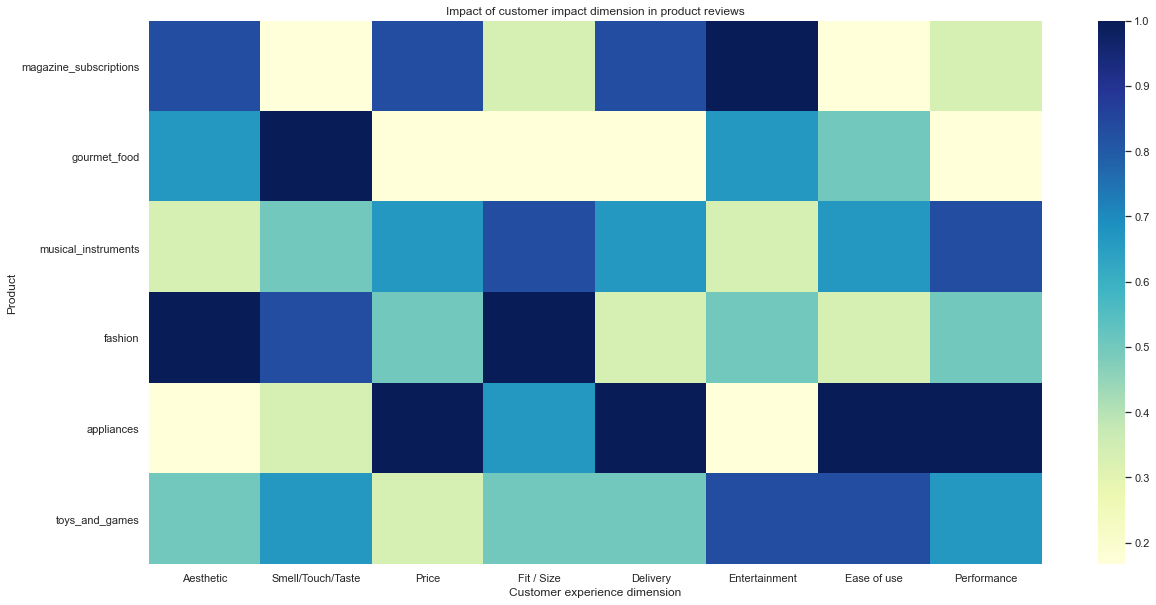

In [7]:
# Read in pretrained embeddings
path_to_glove_pretrained = '/Users/louisgenereux/Desktop/Term 4/Text_analytics/glove.6B/glove.6B.100d.txt'
embeddings_glove = read_pretrained_embeddings(path_to_glove_pretrained)
glove_words = list(embeddings_glove.keys())
print('- pretrained glove embeddings read in')

# Read in logistic regression parameters summary
parameters_summary = pd.read_csv('logistic_regression_parameters.csv')
print('- logistic regression parameters summary read in')

# Define dimensions for product evaluation
dim_aesthetic = ['beautiful', 'ugly', 'appearance']
dim_appeal_to_senses = ['sensory', 'smelly', 'aromatic']
dim_price = ['money', 'expensive', 'affordable']
dim_size = ['fit', 'bulky', 'weight']
dim_punctuality = ['delivery', 'delay', 'timely']
dim_entertainment = ['boring', 'fun', 'literature']
dim_ease_of_use = ['demanding', 'straightforward', 'intuitive']
dim_product_quality = ['functional', 'operational', 'defective']

# Create list of all words used to define dimensions
list_dimensions = [dim_aesthetic, dim_appeal_to_senses, dim_price, dim_size, dim_punctuality, dim_entertainment,
                   dim_ease_of_use, dim_product_quality]
# dimension_names = ['visual aesthetic', 'sensory appeal (smell, touch taste)', 'price', 'size, weight and fit',
#                   'delivery / punctuality', 'entertainment power', 'ease / difficulty of use',
#                   'performance and quality']
dimension_names = ['Aesthetic', 'Smell/Touch/Taste', 'Price', 'Fit / Size',
                   'Delivery', 'Entertainment', 'Ease of use', 'Performance']

# Extract the top 5 synonyms for each word used to describe dimensions
nn_for_dimensions = return_n_nn_for_all_dimensions(list_dimensions, dimension_names, 5)
print('- Synonym of dimension descriptors identified, embeddings stored ')

# Evaluate similarity of each logit parameter versus dimension descriptors
results = evaluate_paremeter_versus_dimension(parameters_summary, nn_for_dimensions,
                                              embeddings_glove, glove_words)
results['category'] = list(map(lambda cat_word: cat_word.split('-')[0], results['category_word']))
print('- All logit parameters evaluated (proximity to dimensions)')

# List of all the categories considered
unique_categories = list(results.category.value_counts().index)

# Aggregate logit parameter similarity to dimension for each product category (one row per product type)
results_agg = calculate_agg_dim_score_for_each_category(unique_categories, results)
print('- Parameter proximity to dimension aggregated at product level (weighted by parameter importance')

# Scale aggregate results
results_agg_scaled = scale_agg_summary(results_agg, 1, dimension_names)
print('+ Scaled aggregated proximity:')
print(results_agg_scaled)

# Evaluate relative importance
relative_dimension_importance = pd.DataFrame()
relative_dimension_importance['product_category'] = results_agg['product_category']
for i in dimension_names:
    relative_dimension_importance[i] = results_agg[i].rank() / 6

dimension_importance_with_index = relative_dimension_importance
dimension_importance_with_index = dimension_importance_with_index.set_index('product_category')

# Visualize heatmap
print('+ Heatmap:')
# heatmap_product_dimensions(dimension_names, results_agg_scaled)
# heatmap_product_dimensions_png(dimension_names, results_agg_scaled)
plot_sns_heatmap(dimension_importance_with_index)

# Compare 2 product categories
plot_product_comparaison('appliances', 'musical_instruments', dimension_names, relative_dimension_importance)